step, unique_state_no
0, 1
1, 5
2, 17
3, 18
4, 13
5, 3
6, 0
7, 0
8, 0
9, 0
10, 0
Graph size (game-state complexity = Groesse): 57
Ordnung:  160
somebody_wins:  17


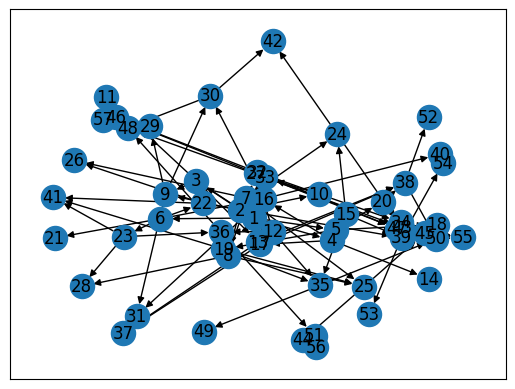

In [4]:
# ue1, Jack Heseltine
# 1.6

# based on https://veliugurguney.com/blog/post/all_states_of_tic_tac_toe
# core idea: data structure of symmetry groups, because "Unlike chess tic-tac-toe does not have 
#   a sense of direction. Some board configurations are equivalent to others. For example, initially 
#   putting an X at the top left corner or top right corner does not matter in terms of strategy. 
#   You can rotate the board 90 degrees counter-clockwise and have the same state 
#   (Or turn your head 90 degrees clockwise. Hehe.)"

from collections import deque
from typing import Iterable, List

#
# Data Structures
#

# Represents one board configuration.
# Other constraints of a State type
#   inner tuple is made of 3 integers, a triplet made of {0, 1, 2}
#   and outer tuple is made of 3 triplets.
State = Iterable[Iterable[int]]

# Constraint on SymmetryGroup type is that
# states it includes has to be symmetric under
# rotation and mirroring.
# Also first state in the list is the
# canonical representation of the group.
SymmetryGroup = List[State]

# Represent the ID of individual Symmetry Groups
GroupId = int

# this all adds up to:
class Node(object):
    def __init__(self, val: GroupId = None, successors: List[GroupId] = None):
        self.val = val
        self.successors = successors or []


#
# Debug utilities
#

def state_str(st: State) -> str:
    def row_to_str(row: Iterable[int]):
        row = [str(num) for num in row]
        return "".join(row)

    return "\n".join(row_to_str(row) for row in st)


def print_state(st: State) -> None:
    print(state_str(st))


def print_states(states: Iterable[State]):
    for st in states:
        print_state(st)
        print()


#
# Algorithms
#
def get_symmetries(st: State) -> SymmetryGroup:
    """Compute Symmetry Group of a board state.

    There are 8 symmetries of a state. Identity + 3 90 degree
    rotations. And the same for it's mirror (either horizontal
    or vertical.)

    Also remove duplicate states in a group.

    Keeps the original state to be used to compute the group
    at the first index, so that it can be used as the
    "canonical state" that represents the group.
    """

    def get_vertical_mirror(st: State) -> State:
        return tuple(reversed(st))

    def get_rotations(st: State) -> List[State]:
        # fmt: off
        ((a, b, c),
         (d, e, f),
         (g, h, i)) = st
        rot1 = ((g, d, a),
                (h, e, b),
                (i, f, c))
        rot2 = ((i, h, g),
                (f, e, d),
                (c, b, a))
        rot3 = ((c, f, i),
                (b, e, h),
                (a, d, g))
        # fmt: on
        return [st, rot1, rot2, rot3]

    def apply_all_symmetry_operations(st: State) -> List[State]:
        mir = get_vertical_mirror(st)
        return get_rotations(st) + get_rotations(mir)

    all_symmetries = apply_all_symmetry_operations(st)
    duplicates_removed = list(dict.fromkeys(all_symmetries))
    return duplicates_removed


def is_end(st: State) -> bool:
    """Tell whether given state is a game-ending state.

    Go over every column, row and diagonals (lines) and
    check whether they are made of all-Xs or all-Os.
    """

    def are_same(triplet):
        a, b, c = triplet
        return a == b == c != 0

    horizontals = [[st[ix][0], st[ix][1], st[ix][2]] for ix in range(3)]
    verticals = [[st[0][ix], st[1][ix], st[2][ix]] for ix in range(3)]
    diag1 = [st[0][0], st[1][1], st[2][2]]
    diag2 = [st[2][0], st[1][1], st[0][2]]
    lines = horizontals + verticals + [diag1, diag2]

    return any(are_same(line) for line in lines)


def make_move(st: State, row: int, col: int, val: int) -> State:
    """Take a state and a move and creates resulting state.

    Do not check the legality of the move."""
    mutable_st = [list(r) for r in st]
    mutable_st[row][col] = val
    new_st = tuple(tuple(r) for r in mutable_st)
    return new_st


def get_next_states_raw(st: State, step: int) -> List[State]:
    """Compute states that can be reach via legal moves.

    Given a state and the number of current step.
    Assuming empty board is step=0, X's are placed in even <-- not in angabe, other way
    steps and O's in odd steps.

    If given state is an ending state, there no next states.
    """
    next_states = []
    if is_end(st):
        return []
    new_val = step % 2 + 1
    for row in range(3):
        for col in range(3):
            val = st[row][col]
            if val == 0:
                new_st = make_move(st, row, col, new_val)
                next_states.append(new_st)
    return next_states



#
# Main
#
if __name__ == "__main__":
    initial_board_state = ((2, 0, 2), (0, 1, 0), (0, 0, 1)) 
    # index from states (hashable since tuple) to symmetry group ids
    states = {}
    # index from symmetry group id to actual groups
    groups = {}
    # index from symmetry group id to Node that hold them in the DAG
    nodes = {}
    # Incremental counter of GroupIds
    gid = 1

    def add_symmetry_group(st: State, gid: GroupId):
        """Compute symmetry group, update global state.

        Should be called when a new unique state is encountered.
        Register computed group into `groups` via given `gid`.
        Store the belonging of the states of the group in `states.
        """
        global states, groups
        assert gid not in groups
        symmetry_group = get_symmetries(st)
        groups[gid] = symmetry_group
        states.update({st: gid for st in symmetry_group})

    # Handle initial state
    add_symmetry_group(initial_board_state, gid)
    root = Node(gid)
    nodes[gid] = root
    gid += 1

    # set up basic double-ended-queue
    q = deque([root])

    # keep counts: "End-Zustaende"
    x_wins = 0
    o_wins = 0
    nobody_wins = 0 # defined as full board, but NOT is_end()
    # for testing
    somebody_wins = 0

    def compute_and_queue_successors(nd: Node) -> None:
        global groups, nodes, q, gid, somebody_wins, x_wins, o_wins, nobody_wins
        sym_group = groups[nd.val]
        # first state of a group is its representative state
        canonical_state = sym_group[0]
        
        # counts, check against canonical state
        if is_end(canonical_state):
            somebody_wins += 1

        next_states = get_next_states_raw(canonical_state, step)
        for nxt_st in next_states:
            # have seen/processed this state before?
            if nxt_st in states:
                gid_old = states[nxt_st]
                # merge this path with other paths leading to this node
                # if it is not already merged (i.e. if not a successor
                # of current node)
                if gid_old not in [suc.val for suc in nd.successors]:
                    nd.successors.append(nodes[gid_old])
                continue
            # is it an unseen/unprocessed state?
            add_symmetry_group(nxt_st, gid)
            new_nd = Node(gid)
            nodes[gid] = new_nd
            nd.successors.append(new_nd)
            q.appendleft(new_nd)
            gid += 1

    # BDS from root Node.
    print("step, unique_state_no")
    for step in range(11):
        print(f"{step}, {len(q)}")
        for _ in range(len(q)):
            compute_and_queue_successors(q.pop())

    print("Graph size (game-state complexity = Groesse):", len(nodes))
    # print_states([groups[nd.val][0] for nd in root.successors])
    # print_states([groups[nd.val][0] for nd in root.successors[2].successors])

    # Plot graph
    edges = []  # List[(GraphId, GraphId)]

    def traverse(nd):
        global edges
        edges.extend([(nd.val, s.val) for s in nd.successors])
        for s in nd.successors:
            traverse(s)

    traverse(root)

    import networkx as nx

    G = nx.DiGraph()
    G.add_edges_from(edges)
    nx.draw_networkx(G, with_labels=True, arrows=True)
    
    print("Ordnung: ", len(edges))

    print("somebody_wins: ", somebody_wins)

    
    